In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyjags
import pystan
import pickle

from pystan import StanModel
from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole





In [25]:
## function to draw from truncated normal, this function will be used for both the 
## one- and two-componenet cases in this workbook.  

def rnorm_bound( Ndata, mu, prec, lower_bound = 0.0, upper_bound = float('Inf')):
    x = np.zeros(Ndata)
    #print(x)
    for i in range(0, Ndata): 
            #print(i)
            while True:
                x[i] = np.random.normal(mu,prec,1)
                if( (x[i]>lower_bound) and (x[i]<upper_bound) ): 
                    break
    return x;

[-0.0335129  -0.05147497  0.45703297  0.53136163  0.09136242  0.27811756
  0.08401127 -0.29803207  0.18356532 -0.0430541  -0.47439244 -0.11065935
  0.12771399 -0.0377593  -0.22090585  0.05994642  0.09613347  0.11891698
 -0.05178444  0.08419931  0.21923933  0.1393806  -0.31165863  0.21402709
  0.10587647] [-0.01024853 -0.04999624  0.46082758  0.55808659  0.10335101  0.25036061
  0.10520832 -0.30108331  0.20081656 -0.01728241 -0.43282035 -0.14367555
  0.14497739 -0.04150431 -0.2325403  -0.01045193  0.04363763  0.11981175
 -0.07325565  0.1007117   0.18570614  0.12878201 -0.29065041  0.15428562
  0.14154843] [-0.04299039  0.26121505 -0.33294611  0.36907375  0.16816658  0.16667148
  0.29559391 -0.3652624  -0.49721513  0.49178912  0.00691833  0.53572618
 -0.16104821 -0.14242048  0.22128133  0.23113572 -0.4943022   0.23993813
  0.32419822  0.21954593  0.01049429  0.05441174 -0.01411922 -0.43010781
  0.18505888] [-0.04840221  0.33468404 -0.35779549  0.36869667  0.27570737  0.14651745
  0.37486

(array([ 1.,  2.,  2.,  3.,  4.,  8.,  3.,  0.,  0.,  2.]),
 array([-0.43282035, -0.33372965, -0.23463896, -0.13554827, -0.03645757,
         0.06263312,  0.16172382,  0.26081451,  0.3599052 ,  0.4589959 ,
         0.55808659]),
 <a list of 10 Patch objects>)

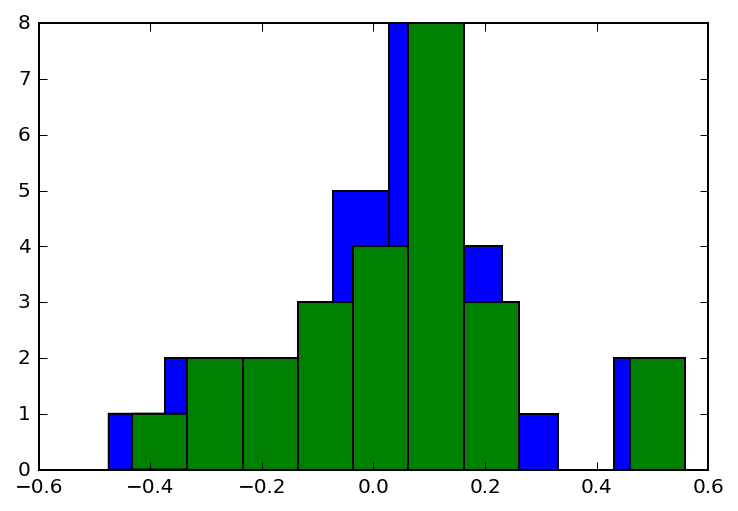

In [27]:
## One-component Gaussian Mixture Simulated Data
## Below we designate the population values of our generative model. These are the 
## truths that we should recover if our hiararchical Bayesian model is properly specified 
## and diagnostics have indicated that the simulation has "not not converged". "You can't 
## prove convergence, at best you can fail to prove a failure to converge".

## In this simulated data set, their are 50 planetary systems (with one planet each)
Ndata = 25 
## Here we asign the dispersion of the simulated population to be 0.3, this is 
## the truth we wish to recovern 
sigmae = 0.3 
## We approximate the uncertainty for each measurement as normally distributed about a 
## reporte measurement point estimate.  For the eccentricity distribution for Hot Jupiter
## the physical models used to derive these produce larger uncertainty in k by a factor of 2. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)


for i in range(0,Ndata):
    h[i] = rnorm_bound(1,0,sigmae,lower_bound=-1,upper_bound=1)
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae,lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

## Vizualize the true data values, and the simulated measurements:     
print(h, hhat, k, khat)
plt.hist(h)
plt.hist(hhat)

In [9]:
eccmodel = """
data {
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=-1,upper=1> khat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
    real<lower=0,upper=1> khat_sigma[Ndata];
}
parameters {
    simplex[Nm] f;
    real<lower=0> e_sigma[Nm];
    real<lower=-1,upper=1> h[Ndata];
    real<lower=-1,upper=1> k[Ndata];
}
model {
    real ps_h[Nm];
    real ps_k[Nm];
    e_sigma ~ uniform(0, 1.0);
    
    for (n in 1:Ndata)
      hhat[n] ~ normal(h[n], hhat_sigma[n]);
    for (n in 1:Ndata)
      khat[n] ~ normal(k[n], khat_sigma[n]);

    for (n in 1:Ndata)
      for (j in 1:Nm) {
        ps_h[j] <- log(f[j]) + normal_log(h[n],0.0,e_sigma[j]);
      }
      // increment_log_prob(log_sum_exp(ps_h));
    for (n in 1:Ndata)
      for (j in 1:Nm) {
        ps_k[j] <- log(f[j]) + normal_log(k[n],0.0,e_sigma[j]);
      }
      increment_log_prob(log_sum_exp(ps_k) * log_sum_exp(ps_h));
      
}
"""
# Compiled Stan Model
sm = StanModel(model_code=eccmodel)

In [ ]:
eccmodel = """
data {
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=-1,upper=1> khat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
    real<lower=0,upper=1> khat_sigma[Ndata];
}
parameters {
    simplex[2] f;
    real<lower=0> e_sigma[2];
    real<lower=-1,upper=1> h[Ndata];
    real<lower=-1,upper=1> k[Ndata];
}
model {
    e_sigma ~ uniform(0, 1.0);
    
    for (n in 1:Ndata)
      hhat[n] ~ normal(h[n], hhat_sigma[n]);
    for (n in 1:Ndata)
      khat[n] ~ normal(k[n], khat_sigma[n]);

    for (n in 1:Ndata)
      increment_log_prob(log_mix(f[1], normal_log(h[n], 0.0, e_sigma[1]), normal_log(h[n], 0.0, e_sigma[2])));
    for (n in 1:Ndata)
      increment_log_prob(log_mix(f[2], normal_log(k[n], 0.0, e_sigma[1]), normal_log(k[n], 0.0, e_sigma[2])));
}
"""
# Compiled Stan Model
sm = StanModel(model_code=eccmodel)

In [ ]:
ecc_dat = {'Nm': 2, 'Ndata': len(df.loc[:, "H_OBS"]), 'alpha': [1], 'hhat': df.loc[:, "H_OBS"], 'khat': df.loc[:, "K_OBS"], 'hhat_sigma': df.loc[:, "H_SIGMA"], 'khat_sigma': df.loc[:, "K_SIGMA"]}


fit = sm.sampling(data=ecc_dat, iter=10000, chains=5, seed=483892929, refresh=11000, n_jobs=-1)



In [ ]:
la = fit.extract(permuted=True)  # return a dictionary of arrays

a = fit.extract(permuted=False)

print(la)



In [19]:
print(fit)


Inference for Stan model: anon_model_fc4049d9f8237977c405329db8091880.
5 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=25000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]          0.5  1.5e-4   0.02   0.45   0.48    0.5   0.51   0.54  25000   1.05
f[1]          0.5  1.5e-4   0.02   0.46   0.49    0.5   0.52   0.55  25000   1.05
e_sigma[0]   0.14  7.0e-4   0.11   0.04   0.05   0.05   0.27   0.29  25000  18.34
e_sigma[1]   0.18  7.1e-4   0.11   0.04   0.05   0.26   0.27   0.29  25000  15.05
h[0]         0.51  6.3e-610.0e-4   0.51   0.51   0.51   0.51   0.51  25000    nan
h[1]        -0.03  6.4e-6 1.0e-3  -0.03  -0.03  -0.03  -0.03  -0.02  25000    1.0
h[2]          0.1  6.3e-6 1.0e-3   0.09   0.09    0.1    0.1    0.1  25000    1.0
h[3]         -0.4  6.3e-6 9.9e-4   -0.4   -0.4   -0.4   -0.4   -0.4  25000    nan
h[4]        -0.02  6.4e-6 1.0e-3  -0.02  -0.02  -0.02  -0.02  -0.01  25

In [20]:
e_sigma_1 = la['e_sigma'][:,0]
f_1 = la['f'][:,0]
e_sigma_2 = la['e_sigma'][:,1]
f_2 = la['f'][:,1]

print( np.hstack(( f_1.reshape(-1,1), e_sigma_1.reshape(-1,1), f_2.reshape(-1,1), e_sigma_2.reshape(-1,1) )) ) 

# Sort the sigma high and sigma low values:
e_sigma_low = np.minimum(e_sigma_1,e_sigma_2)
e_sigma_hi = np.maximum(e_sigma_1,e_sigma_1)
 
e_sigma_low_full = np.where(e_sigma_1 <= e_sigma_2, e_sigma_1, e_sigma_2)
e_sigma_hi_full = np.where(e_sigma_1 > e_sigma_2, e_sigma_1, e_sigma_2)
f_low_full = np.where(e_sigma_1 <= e_sigma_2, f_1, f_2)
f_hi_full = np.where(e_sigma_1 > e_sigma_2, f_1, f_2)

print( np.hstack(( f_low_full.reshape(-1,1), e_sigma_low_full.reshape(-1,1), f_hi_full.reshape(-1,1), e_sigma_hi_full.reshape(-1,1) )) ) 


[[ 0.52490027  0.04455185  0.47509973  0.26239911]
 [ 0.48351075  0.04084643  0.51648925  0.26296616]
 [ 0.48511518  0.04501719  0.51488482  0.26599057]
 ..., 
 [ 0.51078252  0.04492869  0.48921748  0.2631538 ]
 [ 0.49644205  0.04531956  0.50355795  0.28503703]
 [ 0.50927693  0.04429432  0.49072307  0.30111837]]
[[ 0.52490027  0.04455185  0.47509973  0.26239911]
 [ 0.48351075  0.04084643  0.51648925  0.26296616]
 [ 0.48511518  0.04501719  0.51488482  0.26599057]
 ..., 
 [ 0.51078252  0.04492869  0.48921748  0.2631538 ]
 [ 0.49644205  0.04531956  0.50355795  0.28503703]
 [ 0.50927693  0.04429432  0.49072307  0.30111837]]


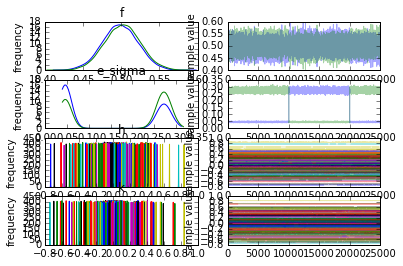

In [21]:
fig = fit.traceplot()

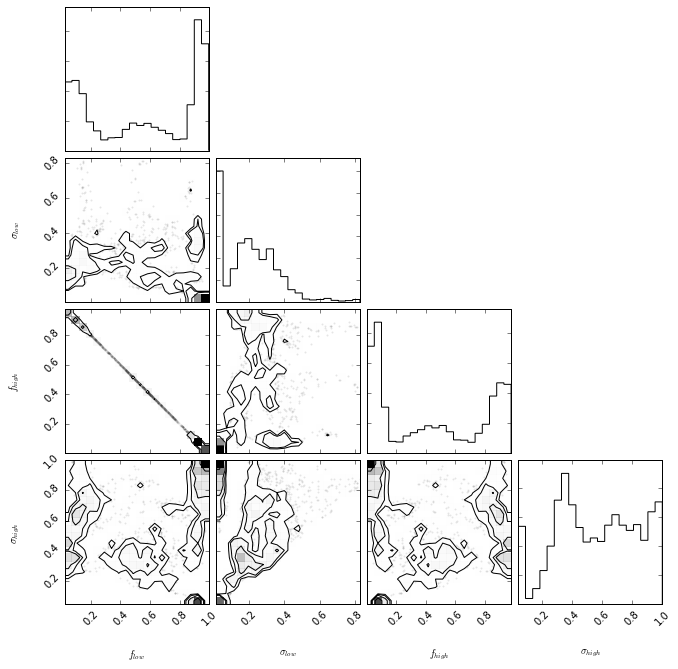

In [15]:
## Use pandas three dimensional Panel to represent the trace:

trace_1_Stan = pd.Panel({k: v for k, v in samples_Nm1_trace_Stan.items()})
trace_1_Stan.axes[0].name = 'Variable'
trace_1_Stan.axes[1].name = 'Iteration'
trace_1_Stan.axes[2].name = 'Chain'
 
## Point estimates:
print(trace_1_Stan.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace_1_Stan.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('{}.png'.format(filename))
 
# Display diagnostic plots
for var in trace_1_Stan:
    plot(trace_1_Stan, var)
 


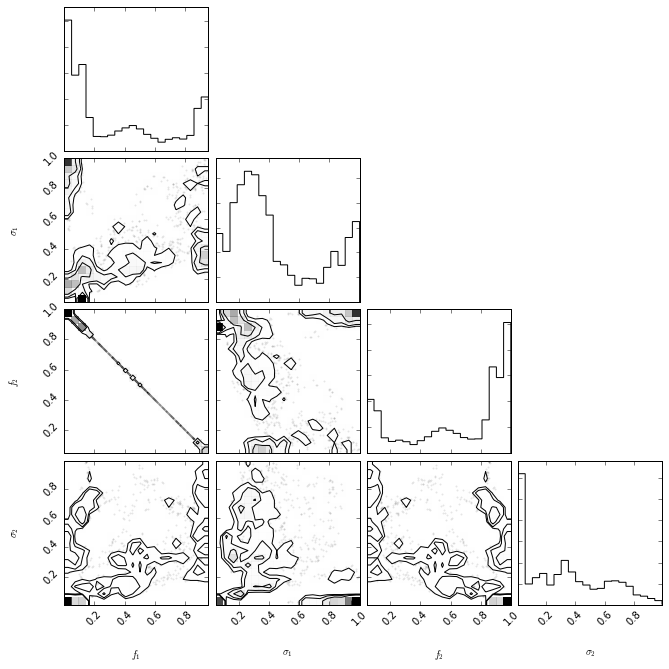

In [19]:
## Scatter matrix plot:
##    If Ndata is increase, this scatter_matrix might do better to skip every nth latent variable
##    Code for that is in a future code cell, where we make a triangle plot with KDE for 
##    joint 2D marginals. scatter_matrix is a Python Pandas module.

sm = scatter_matrix(trace_1_Stan.to_frame(),  color="#00BFFF", alpha=0.2, figsize=(dim1*2, dim1*2), diagonal='hist',hist_kwds={'bins':25,'histtype':'step', 'edgecolor':'r','linewidth':2})

## y labels size
[plt.setp(item.yaxis.get_label(), 'size', 20) for item in sm.ravel()]

## x labels size 
[plt.setp(item.xaxis.get_label(), 'size', 20) for item in sm.ravel()]

## Change label rotation.  This is helpful for very long labels
#[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]

[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

## May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

## Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

## Save the figure as .png 
plt.savefig('scatter_matrix_Nm2_Stan.png')


In [21]:
divergent = get_sampler_params(fit_cp80, inc_warmup=FALSE)[[1]][,'divergent__']
sum(divergent)

SyntaxError: invalid syntax (<ipython-input-21-dc9cc1516e76>, line 1)